<span style="color:red">
To get this notebook running, please install: <br> 
1. sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config <br>
2. pip install pygraphviz
</span>

In [81]:
# change working dir of notebook
%load_ext autoreload
%autoreload 2
%cd /home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24/

import torch
import matplotlib.pyplot as plt
from clustpy.data import load_fmnist, load_mnist, load_reuters, load_usps
from clustpy.deep.autoencoders import FeedforwardAutoencoder
import random
import numpy as np
from practical.DeepClustering.DeepECT.evaluation_pipeline import get_custom_dataloader_augmentations, DatasetType
from practical.DeepClustering.DeepECT.deepect import DeepECT
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import networkx as nx
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/schilcherj/master/deepClustering/LMU_Master_Practical_SoSe24


/home/schilcherj/master/deepClustering/deepClustEnv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Visualization of pretrained autoencoder

In [86]:
def visualize_peformance_AE(param_path_autoencoder: str, autoencoder_class: torch.nn.Module, dataset, image_size: tuple, number_samples: int, seed: int = None):

    if seed is not None and type(seed) == int:
        random.seed(seed)
    
    data = dataset["data"]
    labels = dataset["target"]

    autoencoder = autoencoder_class(layers=[data.shape[1], 500, 500, 2000, 10])
    autoencoder.load_state_dict(torch.load(param_path_autoencoder)) 

    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    for i, index in enumerate(sorted(random.sample(range(data.shape[0]),number_samples))):
        img = data[index]
        if img.ndim == 1:
            img = np.expand_dims(img,0)
        img_rec = autoencoder.decode(autoencoder.encode(torch.from_numpy(img))).detach().numpy()
        ax[i].imshow(img.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i+number_samples].imshow(img_rec.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i].set_title(f'original')
        ax[i+number_samples].set_title(f'reconstructed')
        ax[i].set_axis_off()
        ax[i+number_samples].set_axis_off()
    
    plt.figure()
    pca = PCA(n_components=2)
    projected_data = pca.fit_transform(autoencoder.encode(torch.from_numpy(data)).detach().clone().numpy())
    plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap='viridis')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of embedded space')
    plt.colorbar(label='Digit')
    plt.show()
        

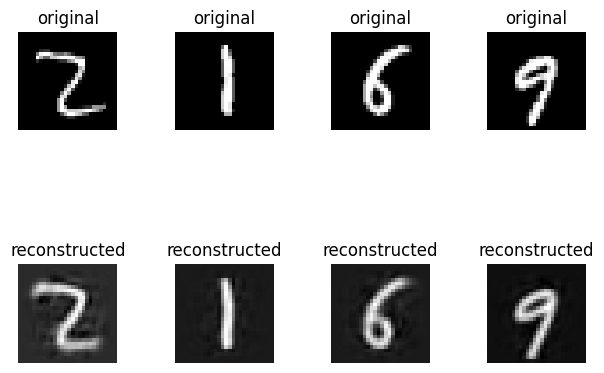

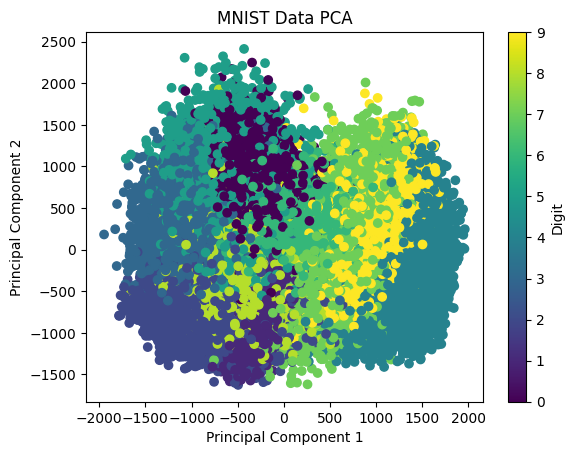

In [87]:
# 1. change data to new dataset
# 2. Change param file path to autoencoder of this dataet
# 3. Change image size for this dataset (usps:16x16, (f)mnist:28x28)
dataset = load_mnist()
data = dataset["data"]
labels = dataset["target"]
visualize_peformance_AE("./practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_autoencoder_pretrained.pth", FeedforwardAutoencoder, dataset, (28,28),4, seed=0)

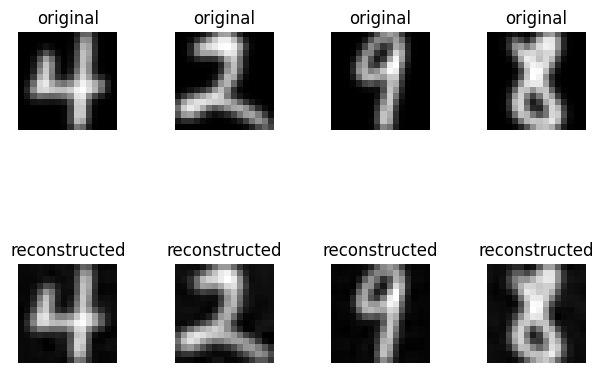

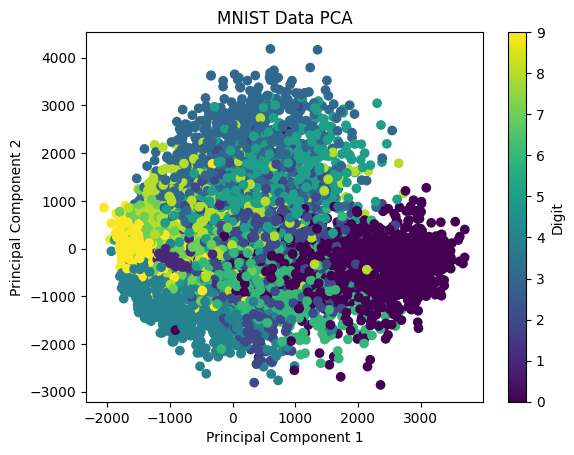

In [88]:
dataset = load_usps()
visualize_peformance_AE("./practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_autoencoder_pretrained.pth", FeedforwardAutoencoder, dataset,(16,16),4, seed=15)

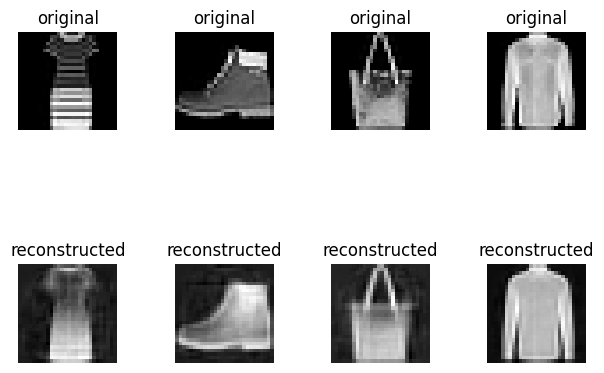

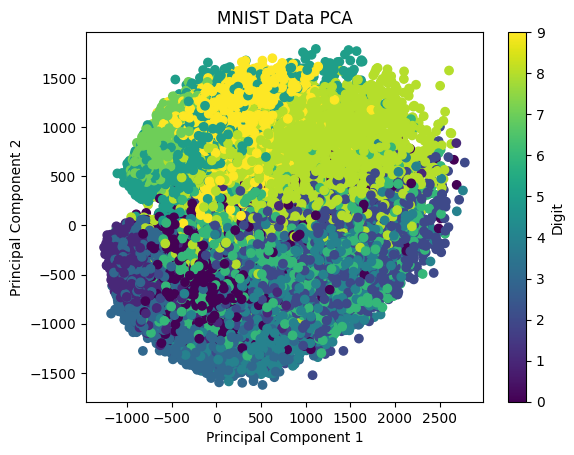

In [89]:
dataset = load_fmnist()
visualize_peformance_AE("./practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_autoencoder_pretrained.pth", FeedforwardAutoencoder, dataset,(28,28),4, seed=5)

### Visualization of augmented data

In [47]:
def show_augmented_data(data: np.ndarray, dataset_type: DatasetType, image_size: tuple, number_samples: int, seed: int):
    
    if seed is not None and type(seed) == int:
        random.seed(seed)

    (trainloader, _) = get_custom_dataloader_augmentations(data, dataset_type)
    idx, M, M_aug = next(iter(trainloader))

    fig, ax = plt.subplots(2, number_samples)
    fig.tight_layout()
    ax = ax.flatten()
    for i, index in enumerate(sorted(random.sample(range(M.shape[0]),number_samples))):
        img = M[index]
        img_aug = M_aug[index]
        if img.ndim == 1:
            img = np.expand_dims(img,0)
        ax[i].imshow(img.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i+number_samples].imshow(img_aug.reshape(image_size[0],image_size[1]), cmap='gray')
        ax[i].set_title(f'original')
        ax[i+number_samples].set_title(f'augmented')
        ax[i].set_axis_off()
        ax[i+number_samples].set_axis_off()
        

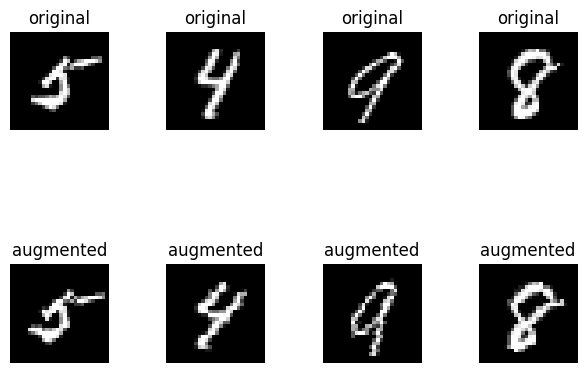

In [55]:
dataset = load_mnist()
data = dataset["data"]
labels = dataset["target"]
show_augmented_data(data, DatasetType.MNIST, (28,28), 4, 3)

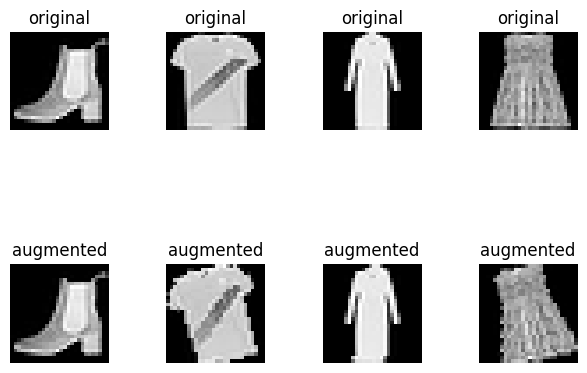

In [50]:
dataset = load_fmnist()
data = dataset["data"]
labels = dataset["target"]
show_augmented_data(data, DatasetType.FASHION_MNIST, (28,28), 4, 1)

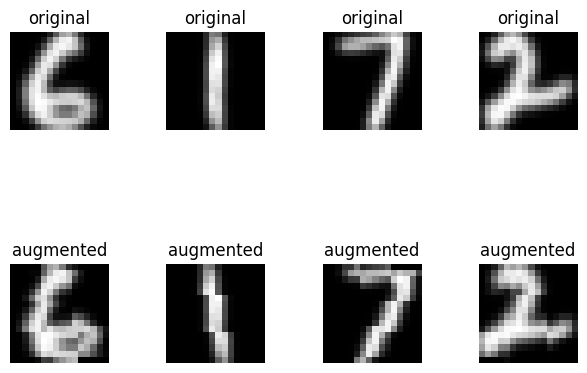

In [62]:
dataset = load_usps()
data = dataset["data"]
labels = dataset["target"]
show_augmented_data(data, DatasetType.USPS, (16,16), 4, 50)

### Visualization of DeepECT Cluster Tree

In [125]:
def graphviz_layout_binary_tree(G, root):
    A = nx.nx_agraph.to_agraph(G)
    A.layout(prog='dot')  # 'dot' is used for hierarchical layouts
    pos = {}
    for node in G.nodes():
        x, y = A.get_node(node).attr['pos'].split(',')
        pos[node] = (float(x), float(y))
    return pos

def build_and_visualize_tree(root, autoencoder, dataset_type):
    if root is None:
        return

    # Create a directed graph
    G = nx.DiGraph()
    
    # Helper function to add nodes and edges to the graph
    def add_edges(G, node):
        if node.left_child:
            G.add_edge(node, node.left_child)
            add_edges(G, node.left_child)
        if node.right_child:
            G.add_edge(node, node.right_child)
            add_edges(G, node.right_child)
    
    # Add nodes and edges starting from the root
    add_edges(G, root)

    # Create a position dictionary for the nodes
    pos = graphviz_layout_binary_tree(G, root)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw(G, pos, ax=ax, with_labels=False)
    
    # Draw the images at the nodes
    for node in G.nodes:
        center = torch.from_numpy(np.expand_dims(node.center, axis=0))
        
        image = autoencoder.decode(center).detach().numpy()
        
        if dataset_type == DatasetType.USPS:
            image = image.reshape(16,16)
        else:
            image = image.reshape(28,28)
        imagebox = OffsetImage(image, zoom=1)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)
    
    plt.show()

def visualize_cluster_tree(dataset_type, autoencoder_param_path, autoencoder_class):
    if dataset_type == DatasetType.FASHION_MNIST:
        dataset = load_fmnist()
    elif dataset_type == DatasetType.MNIST:
        dataset = load_mnist()
    elif dataset_type == DatasetType.USPS:
        dataset = load_usps()
    else:
        raise ValueError(f"data set type {dataset_type} not supported")
    
    data = dataset["data"]
    labels = dataset["target"]

    autoencoder = autoencoder_class(layers=[data.shape[1], 500, 500, 2000, 10])
    autoencoder.load_state_dict(torch.load(autoencoder_param_path))
    autoencoder.fitted = True
    
    deepect = DeepECT(
                    autoencoder=autoencoder,
                    clustering_optimizer_params={"lr": 1e-4, "betas": (0.9, 0.999)},
                    max_leaf_nodes=20,
                    random_state=np.random.RandomState(42)
                )

    deepect.fit(data)

    print("Accuracy: ", deepect.tree_.flat_accuracy(labels, 10))

    build_and_visualize_tree(deepect.tree_.root, autoencoder, DatasetType.MNIST)

In [ ]:
visualize_cluster_tree(DatasetType.MNIST, "./practical/DeepClustering/DeepECT/pretrained_autoencoders/MNIST_autoencoder_pretrained.pth", FeedforwardAutoencoder)

In [ ]:
visualize_cluster_tree(DatasetType.FASHION_MNIST, "./practical/DeepClustering/DeepECT/pretrained_autoencoders/FashionMNIST_autoencoder_pretrained.pth", FeedforwardAutoencoder)

In [126]:
visualize_cluster_tree(DatasetType.USPS, "./practical/DeepClustering/DeepECT/pretrained_autoencoders/USPS_autoencoder_pretrained.pth", FeedforwardAutoencoder)

cpu


Fit:   1%|          | 425/50000 [00:19<37:49, 21.85it/s]


KeyboardInterrupt: 